## Load Data, Define Basis

The goal for this notebook is to test how well a graph neural network architecture can predict the solubility of molcules using the AqSolDB dataset. Therefore, I am going to work with fairly maximalist node and edge bases here, with a very minial global basis. Basically, I added every descriptor that I could find in RDKit that might help the model learn about how molecules work.

My global features are just concatenated to my final graph embedding, so for the purposes of learning about the how well the graph network architecture works, I have left it pretty sparse, rather than injecting lots of molecule-level information alongside my embeddings. I would like to explore adding much more information later, to see just how good you can make a model. For now, it will be about comparing against linear models.

Using code explained in the previous notebook, I load the dataset, split into my training/validation/testing sets, define my basis, and fit my `FeatureBasis` transformer.

In [2]:
from rdkit.Chem.Descriptors import MolWt

from SolGnn.config import project_root
from SolGnn.graphs import FeatureBasis, AtomFeatureSpec, BondFeatureSpec, GlobalFeatureSpec
from SolGnn.data import get_dataset


dataset_path = project_root() / "data" / "clean-dataset.csv"
dataset = get_dataset(dataset_path)

#---------- Define my feature specifications -----
atom_spec = AtomFeatureSpec(
    one_hot=["GetSymbol","IsInRing"],
    scaled=["GetFormalCharge", "GetTotalNumHs", "GetMass", "GetAtomicNum","GetNumRadicalElectrons","GetTotalValence","GetHybridization","GetDegree"]
)

bond_spec = BondFeatureSpec(
    one_hot=["GetBondTypeAsDouble", "IsInRing"],
    scaled=[]
)

global_spec = GlobalFeatureSpec(
    scaled=[MolWt],
)

# ---------- instantiate FeatureBasis and train
basis = FeatureBasis(atom_spec, bond_spec, global_spec)
basis = basis.fit(dataset.X_train)

## The Graph Neural Network (GNN)

In [3]:
from SolGnn.GNN import MolGNN

data_point = basis.transform([dataset.X_train[0]])[0] # grab a random molecule as torch.Data

# The model needs to know the shape of the features it will be receiving
node_in_dim = data_point.x.shape[-1]
edge_in_dim = data_point.edge_attr.shape[-1]
global_in_dim = data_point.global_feat.shape[-1]

model = MolGNN(
    node_in_dim = node_in_dim,
    edge_in_dim = edge_in_dim,
    global_in_dim = global_in_dim,
    hidden_dim = 64, # hyperparameter
    num_layers = 3 # hyperparameter
)
print(model)

MolGNN(
  (node_in): Linear(in_features=62, out_features=64, bias=True)
  (edge_in): Linear(in_features=6, out_features=64, bias=True)
  (convs): ModuleList(
    (0-2): 3 x GINEConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    ))
  )
  (global_mlp): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (aggr): SoftmaxAggregation(learn=True)
  (head): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)


On instantiation, the `MolGNN` module takes the dimensions of the feature vectors for the graph’s nodes, edges, and global attributes. For nodes and edges, `MolGNN` defines input embedding layers. These are linear layers that project the node and edge feature tensors into a higher-dimensional latent space with dimension hidden_dim. The intent is that message passing in this shared latent space allows the model to learn chemically meaningful features of molecules, and how these features relate to aqueous solubility.

`MolGNN` then defines a configurable number of hidden graph layers. In each layer, node features are updated through a round of message passing using the `GINEConv` module from `pytorch_geometric`, which explicitly incorporates edge features into the message computation. Each message passing step is parameterized by a small multilayer perceptron (MLP), and nonlinearity is introduced after each update using the ReLU activation function.

Because molecular graphs vary in size, a graph-level aggregation step is required to produce a fixed-size representation. After message passing, the node embeddings are aggregated into a single graph embedding using a learned aggregation function. This produces a vector of shape (`hidden_dim`) that summarizes the molecular graph.

Global molecular descriptors do not participate directly in message passing. Instead, these features are embedded separately using another MLP, again mapping them into the `hidden_dim` latent space. The resulting global embedding is then concatenated with the graph embedding, combining information learned from the molecular topology with precomputed global descriptors. Separating message passing through the graph from global features will hopefully allow the model to learn local chemical interactions that influence solubulity, independently from molecule-level descriptors.

Finally, the concatenated graph-level and global representations are passed through a small output MLP. This network allows interaction between the two representations and gradually reduces the feature dimension through a sequence of linear layers and ReLU activations. The final output is a single scalar value, which will be the predicted solubility.

The hyperparameters for this framework that will be investigated are:
- `hidden_dim`
- `num_layers`
- `aggr`

Convenionally, `hidden_dim` and `num_layers` allow for more deep learning as these values are increasing. This comes at the cost of model size/training time. We are also not working with a massive dataset, so it likely isn't possible to scale performance with size for very long here. Hence the need for optimization. The `aggr` will be some number of `pytorch_geometric` aggregation and/or pooling functions. It is not clear what approach will offer the most benefit here, so I would like to test a few different options to find the best one.

Here is a summary of the data inputs and outputs for this model.

| Tensor             | Shape      | Description                      |
|--------------------|------------|----------------------------------|
| `data.x`           | `(N, F_n)` | Node (atom) features             |
| `data.edge_index`  | `(2, E)`   | Edge index list                  |
| `data.edge_attr`   | `(E, F_e)` | Edge (bond) features             |
| `data.global_feat` | `(1, F_g)` | Graph-level (molecular) features |
| **Output**         | `(1,)`     | Scalar prediction per graph      |

And here is a summary of the steps taken within the `MolGNN` module, where $H = hidden_dim$.

| Stage              | Tensor             | Shape     |
|--------------------|--------------------|-----------|
| Node embedding     | `x`                | `(N, H)`  |
| Edge embedding     | `edge_attr`        | `(E, H)`  |
| After GNN layers   | `x`                | `(N, H)`  |
| Graph embedding    | `graph_embedding`  | `(1, H)`  |
| Global embedding   | `global_embedding` | `(1, H)`  |
| Concatenated       | `[...]`            | `(1, 2H)` |
| Head output        | `out`              | `(1, 1)`  |




## Training

First, I just have to be able to train and evaluate the model. Since I am using a validation set, I will determine when training is over (and what my best model is) based on my loss function vs my validation set. On that note, I am using mean square error (MSE) as my loss function, and ADAM as my optimizer.

In [4]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(basis.transform(dataset.X_train, ys = dataset.y_train_scaled), batch_size = 64)
valid_loader = DataLoader(basis.transform(dataset.X_valid, ys = dataset.y_valid_scaled), batch_size = 64)
test_loader = DataLoader(basis.transform(dataset.X_test, ys = dataset.y_test_scaled), batch_size = 64)

`TrainConfig` contains information used by `SolGnn.train.fit`. It outsources `device` and `batch_size` information for pytorch - just always `"cpu"` and `64` for me right now. More importantly, it is where I define parameters for the early stopping algorithim, working in concert with `fit`. There is also a `seed` parameter defined, using later in the hyperparameter optimization step that makes results reproducible.

`fit` handle the messiness of the pytorch training loop when given an untrained model, data loaders, and `TrainConfig`. It takes the model through `TrainConfig().epochs` training epochs at maximum, and keeps track of the MSE loss vs. the validation set. The training loop in `fit` keeps track of the best validation MSE, and the associated model parameters. When the validation MSE stops improving (the degree of improvement required is defined by `min_delta`), the loop starts counting down until training is stopped early. How long this "countdown" lasts is defined by the `TrainConfig().patience` setting. It's just the number of epochs that can be tolerated with no validation MSE improvement.

What we will see is that the training loss will continue to decrease long after the validation loss does. This is overfitting that will eventually worsen the performance of the model on unseen data (probably). By stopping training early using the validation loss, we can avoid overfitting, while also speeding up the training process by avoiding unnecessary training loops.

`fit` also prints updates on the training process every 20 epochs so that we can track progress. It returns a dataclass that contains:
- the lowest validation loss seen (important for hyperparameter tuning later)
- the epoch that this occured in
- the entire training history (epoch vs. loss)
- The `state_dict` with the parameters for the "best" model

Epoch    1 | train_mse=0.7434 | val_mse=0.633
Epoch   20 | train_mse=0.219 | val_mse=0.244
Epoch   40 | train_mse=0.1855 | val_mse=0.2289
Epoch   60 | train_mse=0.1678 | val_mse=0.2188
Epoch   80 | train_mse=0.1553 | val_mse=0.2137
Epoch  100 | train_mse=0.1449 | val_mse=0.2072
Epoch  120 | train_mse=0.1363 | val_mse=0.1951
Epoch  140 | train_mse=0.1283 | val_mse=0.1959
Epoch  160 | train_mse=0.1231 | val_mse=0.1999


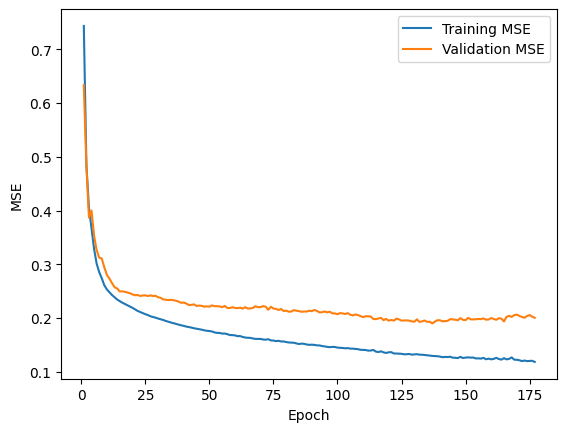

In [5]:
import matplotlib.pyplot as plt

from SolGnn.config import TrainConfig
from SolGnn.train import fit

model = MolGNN(
    node_in_dim = node_in_dim,
    edge_in_dim = edge_in_dim,
    global_in_dim = global_in_dim,
    hidden_dim = 32,
    num_layers = 2
)

train_config = TrainConfig(patience = 40, min_delta = 0.001)

result = fit(model, train_loader, valid_loader, train_config)

# ----- Look at the loss progression
fig,ax = plt.subplots()

epochs = range(1, len(result.history["train_mse"]) + 1)
ax.plot(epochs, result.history["train_mse"])
ax.plot(epochs, result.history["val_mse"])

ax.legend(["Training MSE", "Validation MSE"])
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")

plt.show()


It looks like my early stopping settings are reasonable. The training MSE is continuing to decrease, but my validation MSE levels off. I don't want an overfit model, so when this happens, we stop training, and take the model state with the lowest validation MSE.

I will move forward with these settings into my grid search.

## Hyperparameter Optimization

In [6]:
from torch_geometric.nn.aggr import SoftmaxAggregation, MeanAggregation, SumAggregation # I'll test these three aggregation operators

from SolGnn.config import TrainConfig
from SolGnn.search import run_search

train_config = TrainConfig(patience = 25, min_delta = 0.001)

def make_model(params):
    return MolGNN(
        node_in_dim=node_in_dim,
        edge_in_dim=edge_in_dim,
        global_in_dim=global_in_dim,
        hidden_dim=params["hidden_dim"],
        num_layers=params["num_layers"],
        aggr=params["aggr"]
    )

space = {
    "hidden_dim": [100,150,200,250,300,350],
    "num_layers": [1,2,3,4],
     "aggr": [
         SoftmaxAggregation(learn=True),
         MeanAggregation(),
         SumAggregation()
     ],
}

loaders = {"train": train_loader, "val": valid_loader, "test": test_loader}

`run_search` does a lot of work for me. I feed it a model factory, my data loaders (training, validation, test), the previously discussed `TrainConfig` class, a `space` dictionary with my hyperparameters to test, and a path to save results in.

For each set of hyperparameters, the function runs `fit` with the same set of early stopping settings tested earlier. It collects the results (MSE loss for validation and testing sets), and appends it to my results csv files, along with each set of hyperparameters used, for analysis later.

`run_search` also prints out some information about what's happening, so I can follow along.

Then, the functional saves the model parameters for each model training in `/results/models/` with a unique file name. And it saves the training history to a csv file of the same name under `/results/history/`. This all just allows me to go back and inspect things later without having to re-train models. Furthermore, I can just load the best performing model for testing.

As for the hyperparameter search, I just ran a full-factorial grid search over `hidden_dim`, `num_layers` and `aggr`. This was 72 different models, which was probably a lot, but I just let it run for ~20 hours, and I am happy with my results!

If I were to scale this process - maybe with a lot more data and/or a much deeper hyperparameter search, I would do this training in a parallelized process on a GPU somewhere in the cloud, and I'd like to implement some sort of Bayesian optimization search, rather than a factorial search. But, I just didn't think that was necessary here.

In [7]:
# run the hyperparameter grid search!
run_search(
    make_model=make_model,
    loaders=loaders,
    train_config=train_config,
    space=space,
    csv_relpath="results/grid_search.csv",
)
# this function would print out what was going on
# I ran through this notebook to make sure everything worked before
# uploading, but I wasn't going to re-run this function, because it
# took 20 hours. The results are all saved in the /results directory!

In [8]:
from pandas import read_csv

search_csv = project_root() / "results" / "grid_search.csv"
search_df = read_csv(search_csv)

search_df.sort_values(by='val_mse', ascending=True)

,trial,hidden_dim,num_layers,aggr,best_epoch,val_mse,val_rmse,test_mse,test_rmse
55,55,300,3,MeanAggregation(),81,0.166657,0.408237,0.194316,0.440813
58,58,300,4,MeanAggregation(),79,0.173444,0.416466,0.190844,0.436857
23,23,150,4,SumAggregation(),91,0.174121,0.417278,0.196183,0.442926
14,14,150,1,SumAggregation(),65,0.174866,0.418170,0.181845,0.426433
46,46,250,4,MeanAggregation(),83,0.175541,0.418976,0.184667,0.429729
...,...,...,...,...,...,...,...,...,...
35,35,200,4,SumAggregation(),42,0.203072,0.450636,0.200230,0.447471
47,47,250,4,SumAggregation(),32,0.203444,0.451047,0.209756,0.457991
31,31,200,3,MeanAggregation(),34,0.205661,0.453499,0.199829,0.447022
1,1,100,1,MeanAggregation(),52,0.207015,0.454989,0.213142,0.461673


So, it looks like the best parameters are `hidden_dim=300`, `num_layers=3` with a mean aggregation function. The best performance occured after 81 training epochs.

There doesn't appear to be a massive difference is performance across models with vastly different levels of complexity. This implies that the performance of this graph network arcitecture is more driven by the information provided by node and/or edge features. I think this serves as some confirmation that this is a strong model arcitecture for predicting the solubility of molecules!

## Evaluation

I saved the model state for every set of hyperparameters fitted, so I just need to reload the model with optimal hyperparameters and the fitted model parameters to test it.

In [9]:
from torch import load
from torch_geometric.nn.aggr import MeanAggregation
from SolGnn.viz import predict_loader

best_model = make_model({
    "num_layers":3,
    "hidden_dim":300,
    "aggr":MeanAggregation()
})

best_state_path = project_root() / "results" / "models" / "hidden_dim=300num_layers=3aggr=MeanAggregation().pt"
best_state = load(best_state_path)
best_model.load_state_dict(best_state)

y_true, y_pred = predict_loader(
    best_model,
    test_loader,
    train_config.device,
    dataset.y_scaler
)

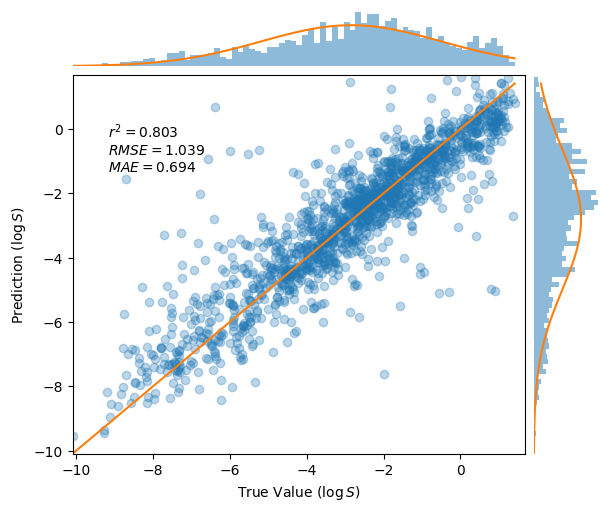

In [10]:
from SolGnn.viz import parity_plot

parity_plot(y_true, y_pred)

It looks like the model is working quite well! I am really happy with how tightly my predictions follow $y=x$. There are certainly some large errors which represent some very poor estimates of molecule solubility, but these appear to be the minority.

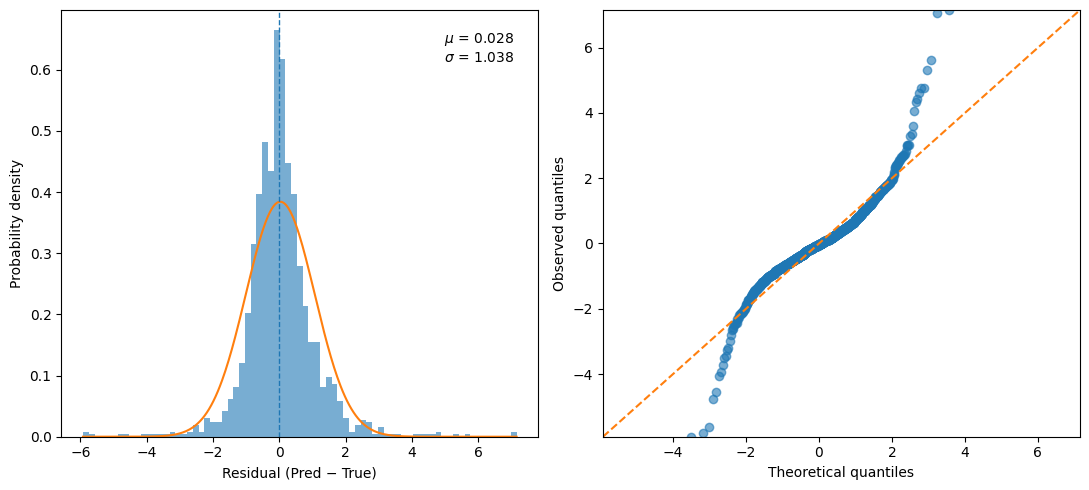

In [11]:
from SolGnn.viz import hist_and_qq_plot

hist_and_qq_plot(y_true,y_pred) # normal distribution was set as the default

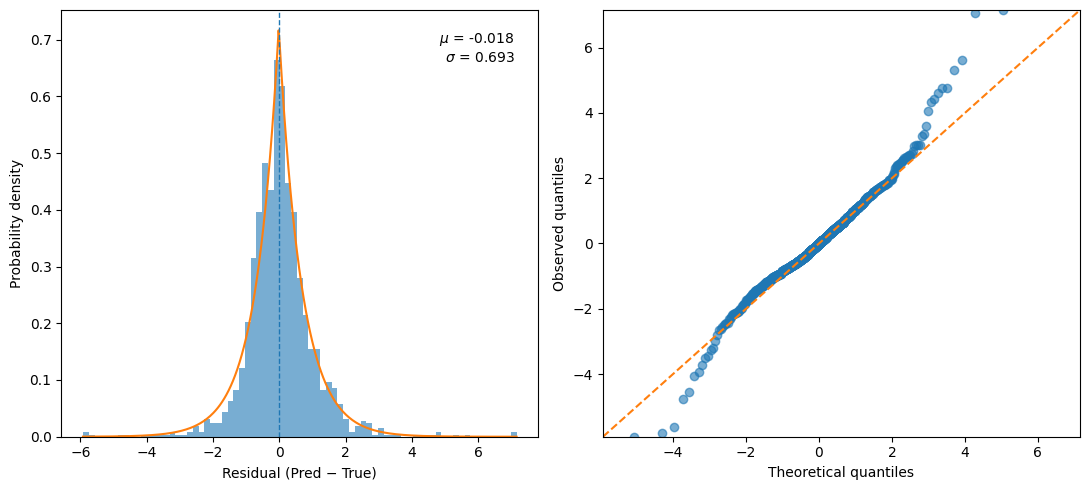

In [12]:
from scipy.stats import laplace

hist_and_qq_plot(y_true,y_pred, prob_func = laplace)

Lastly, inspecting the residuals and qq-plots, it doesn't look like my predictions are biased high or low. Furthermore, a solid majority of the solubility predictions are within an order of magnitude of the true value.

It is clear that the residuals follow a Laplace distrubution much better than a normal distriution. This shows that the model can provide excellent estimates of solubility for a large portion of the molecules in the test set. But, the large tails on the residual is representative of a divsersity in molecules and molecular attributes that the model probably didn't see enough of during training, or features that weren't properly expressed in the contruction of my graph features.